### Mumbai Vibe Map Demo Visualization

In [26]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
import os
from PIL import Image
import base64
from branca.colormap import LinearColormap
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML, Image as IPImage, clear_output
import warnings
warnings.filterwarnings('ignore')

print("🏙️ Mumbai Vibe Map - Interactive Demo")
print("="*50)

🏙️ Mumbai Vibe Map - Interactive Demo


In [27]:
df = pd.read_csv('mumbai_vibe_master_ml_ready.csv')
print(f"📍 Vibes: {', '.join(df['vibe_category'].unique())}")
print(f"🗺️ Areas: {len(df['area'].unique())} unique areas")

📍 Vibes: Ganesh Gully Energy, Kickin' it Old School, Bombay Bhukkad, Chaotic Hustle, Do It For The Gram
🗺️ Areas: 64 unique areas


In [28]:
def get_vibe_color(vibe):
    colors = {
        'Ganesh Gully Energy': '#FF6B35',      
        "Kickin' it Old School": '#8B4513',    
        'Bombay Bhukkad': '#FFD700',     
        'Chaotic Hustle': '#DC143C',        
        'Do It For The Gram': '#FF69B4'        
    }
    return colors.get(vibe, '#808080')

def get_vibe_folder_name(vibe):
    folder_mapping = {
        'Ganesh Gully Energy': 'ganesh_energy',
        "Kickin' it Old School": "kickin'_it_old_school",
        'Bombay Bhukkad': 'bombay_bhukkad',
        'Chaotic Hustle': 'chaotic_hustle',
        'Do It For The Gram': 'do_it_for_the_gram'
    }
    return folder_mapping.get(vibe, '')

def get_image_path(location_id, vibe):
    vibe_folder = get_vibe_folder_name(vibe)
    if not vibe_folder:
        return None
    
    extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
    
    for ext in extensions:
        path = f"images/{vibe_folder}/{location_id}{ext}"
        if os.path.exists(path):
            return path
    return None

def calculate_confidence_score(row):
    confidence = 0.8  # Base confidence
    
    if 'vibe_intensity' in row:
        intensity_factor = (row['vibe_intensity'] - 1) / 4
        confidence += intensity_factor * 0.15
    
    if 'contextual_vibe_intensity' in row and pd.notna(row['contextual_vibe_intensity']):
        contextual_factor = (row['contextual_vibe_intensity'] - 1) / 4
        confidence += contextual_factor * 0.1
    
    non_null_cols = row.notna().sum()
    total_cols = len(row)
    completeness = non_null_cols / total_cols
    confidence += (completeness - 0.5) * 0.1
    
    return max(0.3, min(0.95, confidence))

print("✅ Helper functions loaded")

# Image loading function
def load_and_resize_image(image_path, size=(200, 150)):
    """Load and resize image to standard size"""
    try:
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize(size, Image.Resampling.LANCZOS)
            return img
    except:
        return None

def preload_images():
    """Preload all available images"""
    image_cache = {}
    available_images = 0
    
    print("📸 Loading images...")
    
    for _, row in df.iterrows():
        location_id = row['location_id']
        vibe = row['vibe_category']
        
        img_path = get_image_path(location_id, vibe)
        if img_path:
            img = load_and_resize_image(img_path)
            if img is not None:
                image_cache[location_id] = img
                available_images += 1
    
    print(f"✅ Loaded {available_images} images successfully!")
    return image_cache

# Load images
IMAGE_CACHE = preload_images()


✅ Helper functions loaded
📸 Loading images...
✅ Loaded 150 images successfully!


In [29]:
def show_vibe_overview():
    vibe_counts = df['vibe_category'].value_counts()
    
    fig = px.bar(
        x=vibe_counts.index,
        y=vibe_counts.values,
        color=vibe_counts.index,
        color_discrete_map={vibe: get_vibe_color(vibe) for vibe in vibe_counts.index},
        title="🏙️ Mumbai Vibe Distribution",
        labels={'x': 'Vibe Category', 'y': 'Number of Locations'}
    )
    fig.update_layout(showlegend=False, height=400)
    
    display(fig)

    print(f"\n📊 Dataset Summary:")
    print(f"   Total Locations: {len(df)}")
    print(f"   Average Vibe Intensity: {df['vibe_intensity'].mean():.2f}")
    print(f"   Areas Covered: {df['area'].nunique()}")
    print(f"   Images Available: {len(IMAGE_CACHE)}")

show_vibe_overview()


📊 Dataset Summary:
   Total Locations: 227
   Average Vibe Intensity: 4.22
   Areas Covered: 64
   Images Available: 150


In [ ]:
def create_map(vibe_filter=None, areas=None, show_confidence=False):
    filtered_df = df.copy()
    
    if vibe_filter and vibe_filter != "All Vibes":
        filtered_df = filtered_df[filtered_df['vibe_category'] == vibe_filter]
    
    if areas and len(areas) > 0:
        if isinstance(areas, str):
            areas = [areas]
        filtered_df = filtered_df[filtered_df['area'].isin(areas)]
    
    # Create map
    mumbai_center = [19.0760, 72.8777]
    m = folium.Map(
        location=mumbai_center,
        zoom_start=12,
        tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr='Google Satellite',
        width=1000,
        height=600
    )
    
    # Add street map layer
    folium.TileLayer(
        tiles='OpenStreetMap',
        name='Street Map',
        overlay=False,
        control=True
    ).add_to(m)
    
    if show_confidence:
        # Confidence heat map
        filtered_df['confidence'] = filtered_df.apply(calculate_confidence_score, axis=1)
        
        colormap = LinearColormap(
            colors=['red', 'yellow', 'green'],
            vmin=filtered_df['confidence'].min(),
            vmax=filtered_df['confidence'].max(),
            caption='Model Confidence'
        )
        colormap.add_to(m)
        
        for _, row in filtered_df.iterrows():
            confidence = row['confidence']
            location_id = row['location_id']

            img_html = ""
            if location_id in IMAGE_CACHE:
                from io import BytesIO
                img_bytes = BytesIO()
                IMAGE_CACHE[location_id].save(img_bytes, format='JPEG', quality=85)
                img_base64 = base64.b64encode(img_bytes.getvalue()).decode()
                
                img_html = f"""
                <div style="text-align:center;margin:10px 0;">
                    <img src="data:image/jpeg;base64,{img_base64}" 
                         style="width:180px;height:135px;object-fit:cover;border-radius:5px;"/>
                </div>
                """
            
            popup_html = f"""
            <div style="width:220px;font-family:Arial,sans-serif;padding:5px;">
                <h3 style="color:#333;margin:0 0 10px 0;font-size:16px;text-align:center;">
                    {row['name']}
                </h3>
                {img_html}
                <div style="margin-top:10px;">
                    <p style="margin:3px 0;"><b>Vibe:</b> {row['vibe_category']}</p>
                    <p style="margin:3px 0;"><b>Confidence:</b> {confidence:.1%}</p>
                    <p style="margin:3px 0;"><b>Area:</b> {row['area']}</p>
                    <p style="margin:3px 0;"><b>Intensity:</b> {row['vibe_intensity']:.1f}/5.0</p>
                </div>
            </div>
            """
            
            folium.CircleMarker(
                location=[row['lat'], row['lng']],
                radius=8,
                popup=folium.Popup(popup_html, max_width=240),
                color='white',
                fillColor=colormap(confidence),
                fillOpacity=0.8,
                weight=2,
                tooltip=f"{row['name']} - Confidence: {confidence:.1%}"
            ).add_to(m)
    
    else:
        for _, row in filtered_df.iterrows():
            vibe = row['vibe_category']
            color = get_vibe_color(vibe)
            location_id = row['location_id']

            img_html = ""
            if location_id in IMAGE_CACHE:
                from io import BytesIO
                img_bytes = BytesIO()
                IMAGE_CACHE[location_id].save(img_bytes, format='JPEG', quality=85)
                img_base64 = base64.b64encode(img_bytes.getvalue()).decode()
                
                img_html = f"""
                <div style="text-align:center;margin:10px 0;">
                    <img src="data:image/jpeg;base64,{img_base64}" 
                         style="width:180px;height:135px;object-fit:cover;border-radius:5px;"/>
                </div>
                """
            
            popup_html = f"""
            <div style="width:220px;font-family:Arial,sans-serif;padding:5px;">
                <h3 style="color:{color};margin:0 0 10px 0;font-size:16px;text-align:center;">
                    {row['name']}
                </h3>
                {img_html}
                <div style="margin-top:10px;">
                    <p style="margin:3px 0;"><b>Predicted Vibe:</b> <span style="color:{color};">{vibe}</span></p>
                    <p style="margin:3px 0;"><b>Area:</b> {row['area']}</p>
                    <p style="margin:3px 0;"><b>Type:</b> {row['type']}</p>
                    <p style="margin:3px 0;"><b>Intensity:</b> {row['vibe_intensity']:.1f}/5.0</p>
                </div>
            </div>
            """
            
            folium.CircleMarker(
                location=[row['lat'], row['lng']],
                radius=8,
                popup=folium.Popup(popup_html, max_width=240),
                color='white',
                fillColor=color,
                fillOpacity=0.8,
                weight=2,
                tooltip=f"{row['name']} - {vibe}"
            ).add_to(m)

    folium.LayerControl().add_to(m)
    
    print(f"📍 Showing {len(filtered_df)} locations")
    if len(filtered_df) > 0:
        print(f"📊 Average Intensity: {filtered_df['vibe_intensity'].mean():.2f}")
        areas_list = filtered_df['area'].unique()[:5]
        print(f"🏙️ Areas: {', '.join(areas_list)}")
        if len(filtered_df['area'].unique()) > 5:
            print(f"    ... and {len(filtered_df['area'].unique()) - 5} more")
    
    return m


In [ ]:
def show_gallery(vibe_name, max_locations=9):
    vibe_df = df[df['vibe_category'] == vibe_name].sort_values('vibe_intensity', ascending=False)
    
    print(f"🎯 {vibe_name} Gallery")
    print(f"📍 Found {len(vibe_df)} locations")
    print("="*50)

    for i, (_, row) in enumerate(vibe_df.head(max_locations).iterrows()):
        location_id = row['location_id']
        
        print(f"\n{i+1}. 🏢 {row['name']}")
        print(f"   📍 {row['area']} | ⚡ {row['vibe_intensity']:.1f}/5.0")
        print(f"   🏷️ {row['type']}")

        if location_id in IMAGE_CACHE:
            display(IMAGE_CACHE[location_id])

        if vibe_name == 'Chaotic Hustle':
            if 'commercial_density' in row and pd.notna(row['commercial_density']):
                print(f"   🏪 Commercial Density: {row['commercial_density']:.1f}")
        elif vibe_name == 'Bombay Bhukkad':
            if 'specialty' in row and pd.notna(row['specialty']):
                print(f"   🍽️ Specialty: {row['specialty']}")
        elif vibe_name == "Kickin' it Old School":
            if 'heritage_status' in row and pd.notna(row['heritage_status']):
                print(f"   🏛️ Heritage: {row['heritage_status']}")
        elif vibe_name == 'Do It For The Gram':
            if 'aesthetic_score' in row and pd.notna(row['aesthetic_score']):
                print(f"   📸 Aesthetic Score: {row['aesthetic_score']:.1f}")
        elif vibe_name == 'Ganesh Gully Energy':
            if 'cultural_significance' in row and pd.notna(row['cultural_significance']):
                print(f"   🕉️ Cultural Significance: {row['cultural_significance']:.1f}")
        
        print("-" * 30)

In [ ]:
def show_analytics():

    print("📊 Mumbai Vibe Analytics Dashboard")
    print("="*50)

    print(f"📍 Total Locations: {len(df)}")
    print(f"🏙️ Areas Covered: {df['area'].nunique()}")
    print(f"📸 Images Available: {len(IMAGE_CACHE)} ({len(IMAGE_CACHE)/len(df)*100:.1f}%)")
    print(f"⚡ Average Vibe Intensity: {df['vibe_intensity'].mean():.2f}")

    df_temp = df.copy()
    df_temp['confidence'] = df_temp.apply(calculate_confidence_score, axis=1)
    print(f"🎯 Average Model Confidence: {df_temp['confidence'].mean():.1%}")
    print(f"🟢 High Confidence (>80%): {len(df_temp[df_temp['confidence'] > 0.8])}")
    print(f"🟡 Medium Confidence (60-80%): {len(df_temp[(df_temp['confidence'] >= 0.6) & (df_temp['confidence'] <= 0.8)])}")
    print(f"🔴 Low Confidence (<60%): {len(df_temp[df_temp['confidence'] < 0.6])}")

    print(f"\n🏙️ Top 5 Areas by Location Count:")
    area_counts = df['area'].value_counts().head()
    for area, count in area_counts.items():
        print(f"   {area}: {count} locations")

    print(f"\n⚡ Average Intensity by Vibe:")
    vibe_intensity = df.groupby('vibe_category')['vibe_intensity'].mean().sort_values(ascending=False)
    for vibe, intensity in vibe_intensity.items():
        print(f"   {vibe}: {intensity:.2f}")

    fig = px.box(
        df, 
        x='vibe_category', 
        y='vibe_intensity',
        color='vibe_category',
        color_discrete_map={vibe: get_vibe_color(vibe) for vibe in df['vibe_category'].unique()},
        title="Vibe Intensity Distribution by Category"
    )
    fig.update_layout(showlegend=False, xaxis_title="", height=400)
    fig.update_xaxes(tickangle=45)
    
    display(fig)

    area_vibe = pd.crosstab(df['area'], df['vibe_category'])
    fig_heatmap = px.imshow(
        area_vibe.values,
        x=area_vibe.columns,
        y=area_vibe.index,
        color_continuous_scale='Blues',
        title="Vibe Distribution by Area",
        aspect='auto'
    )
    fig_heatmap.update_layout(height=600)
    
    display(fig_heatmap)

In [39]:
def quick_demo():
    print("🚀 Mumbai Vibe Map - Quick Demo")
    print("="*40)
    for vibe in df['vibe_category'].unique():
        sample = df[df['vibe_category'] == vibe].iloc[0]
        location_id = sample['location_id']
        
        print(f"\n{vibe}:")
        print(f"  📍 {sample['name']} ({sample['area']})")
        print(f"  ⚡ Intensity: {sample['vibe_intensity']:.1f}")
        
        if location_id in IMAGE_CACHE:
            img = IMAGE_CACHE[location_id]
            img_small = img.resize((100, 75))
            display(img_small)

📍 Showing 43 locations
📊 Average Intensity: 4.02
🏙️ Areas: Lalbaug, King's Circle, Wadala, Tejukaya, Khetwadi
    ... and 31 more



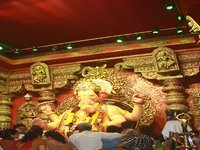
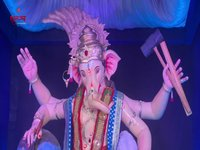
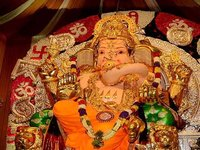
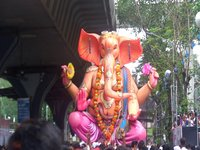
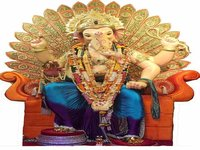
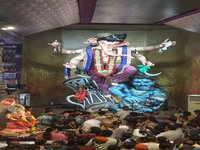
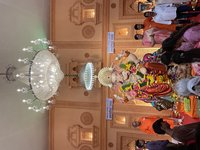
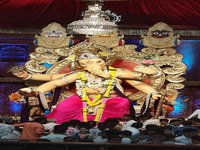
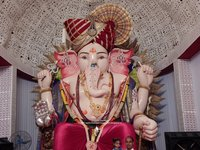
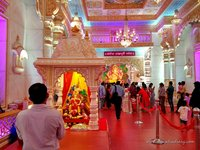
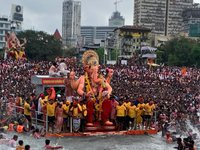
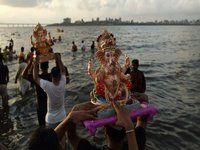
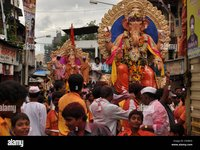
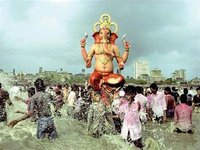
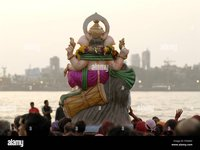
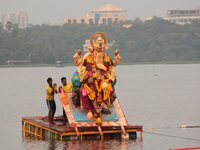
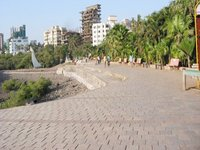
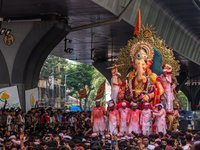
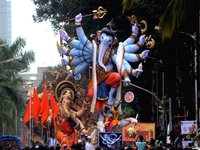
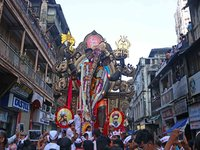
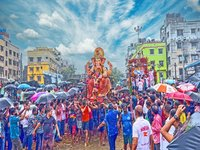
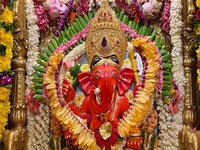
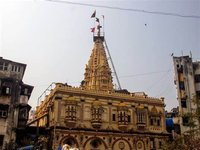
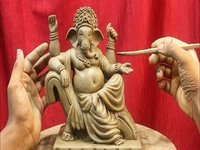
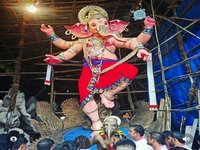
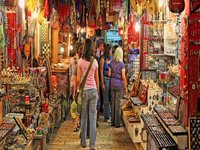
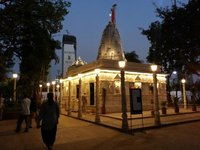
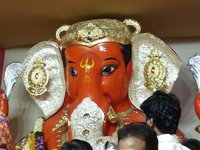

In [34]:
display(create_map('Ganesh Gully Energy'))

🎯 Kickin' it Old School Gallery
📍 Found 47 locations

1. 🏢 Gateway of India
   📍 Colaba | ⚡ 5.0/5.0
   🏷️ Colonial Monument


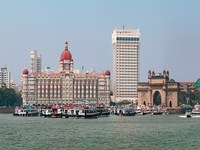

   🏛️ Heritage: UNESCO World Heritage
------------------------------

2. 🏢 Flora Fountain
   📍 Fort | ⚡ 5.0/5.0
   🏷️ Colonial Monument


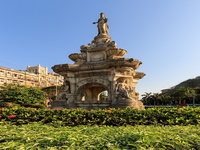

   🏛️ Heritage: Grade I Heritage
------------------------------

3. 🏢 Chhatrapati Shivaji Terminus
   📍 Fort | ⚡ 5.0/5.0
   🏷️ Colonial Railway


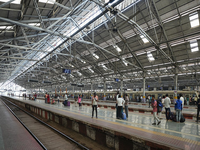

   🏛️ Heritage: UNESCO World Heritage
------------------------------

4. 🏢 Oval Maidan Buildings
   📍 Churchgate | ⚡ 5.0/5.0
   🏷️ Art Deco Residential


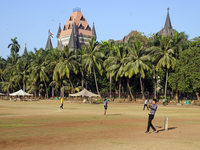

   🏛️ Heritage: UNESCO World Heritage
------------------------------

5. 🏢 Marine Drive Buildings
   📍 Marine Drive | ⚡ 5.0/5.0
   🏷️ Art Deco Residential


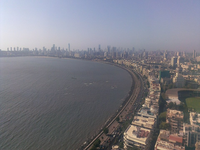

   🏛️ Heritage: UNESCO World Heritage
------------------------------

6. 🏢 Metro Cinema
   📍 Marine Lines | ⚡ 5.0/5.0
   🏷️ Art Deco Cinema


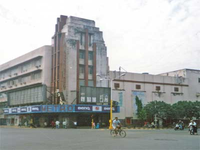

   🏛️ Heritage: UNESCO World Heritage
------------------------------

7. 🏢 Prince of Wales Museum
   📍 Fort | ⚡ 4.9/5.0
   🏷️ Colonial Museum


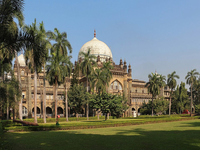

   🏛️ Heritage: Grade I Heritage
------------------------------

8. 🏢 Regal Cinema
   📍 Colaba | ⚡ 4.9/5.0
   🏷️ Art Deco Cinema


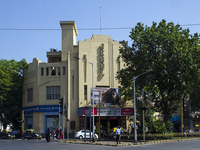

   🏛️ Heritage: UNESCO World Heritage
------------------------------

9. 🏢 Liberty Cinema
   📍 Marine Lines | ⚡ 4.9/5.0
   🏷️ Art Deco Cinema


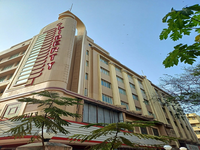

   🏛️ Heritage: UNESCO World Heritage
------------------------------


In [36]:
show_gallery("Kickin' it Old School")

In [37]:
show_analytics()

📊 Mumbai Vibe Analytics Dashboard
📍 Total Locations: 227
🏙️ Areas Covered: 64
📸 Images Available: 150 (66.1%)
⚡ Average Vibe Intensity: 4.22
🎯 Average Model Confidence: 95.0%
🟢 High Confidence (>80%): 227
🟡 Medium Confidence (60-80%): 0
🔴 Low Confidence (<60%): 0

🏙️ Top 5 Areas by Location Count:
   Fort: 31 locations
   Bandra: 24 locations
   Colaba: 14 locations
   Lower Parel: 11 locations
   Dadar: 11 locations

⚡ Average Intensity by Vibe:
   Do It For The Gram: 4.45
   Chaotic Hustle: 4.28
   Kickin' it Old School: 4.21
   Bombay Bhukkad: 4.11
   Ganesh Gully Energy: 4.02


🚀 Mumbai Vibe Map - Quick Demo

Ganesh Gully Energy:
  📍 Lalbaugcha Raja (Lalbaug)
  ⚡ Intensity: 4.8


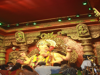


Kickin' it Old School:
  📍 Gateway of India (Colaba)
  ⚡ Intensity: 5.0


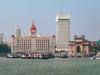


Bombay Bhukkad:
  📍 Mohammed Ali Road (Mohammed Ali Road)
  ⚡ Intensity: 5.0


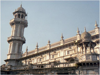


Chaotic Hustle:
  📍 Churchgate Station (Churchgate)
  ⚡ Intensity: 5.0


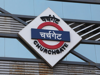


Do It For The Gram:
  📍 Marine Drive (Marine Drive)
  ⚡ Intensity: 5.0


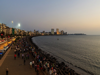

In [38]:
quick_demo()